In [1]:
library(mice)
library(finalfit)
library(ggplot2)
library(dplyr)
library(stats)
library(miceadds)
library(missMethods)
library(smotefamily)
library(caret)
library(cowplot)
library(mlr)
library(fastDummies)
library(DMwR2)
library(mlmi)
library(plot3D)
library(magick)
library(scales)
library(EnvStats)

Warning message:
"pakiet 'mice' został zbudowany w wersji R 4.3.2"

Dołączanie pakietu: 'mice'


Następujący obiekt został zakryty z 'package:stats':

    filter


Następujące obiekty zostały zakryte z 'package:base':

    cbind, rbind


Warning message:
"pakiet 'ggplot2' został zbudowany w wersji R 4.3.3"

Dołączanie pakietu: 'dplyr'


Następujące obiekty zostały zakryte z 'package:stats':

    filter, lag


Następujące obiekty zostały zakryte z 'package:base':

    intersect, setdiff, setequal, union


* miceadds 3.16-18 (2023-01-06 10:54:00)

Ładowanie wymaganego pakietu: lattice

Warning message:
"pakiet 'cowplot' został zbudowany w wersji R 4.3.2"
Warning message:
"pakiet 'mlr' został zbudowany w wersji R 4.3.2"
Ładowanie wymaganego pakietu: ParamHelpers

Warning message:
"pakiet 'ParamHelpers' został zbudowany w wersji R 4.3.2"
Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to t

### Functions definitions

In [2]:
newblots <- function(old_blots, param_list){
    #' Create new blots for narfcs imputation.
    
    new_blots <- old_blots
    for (i in names(new_blots)) {
    par <- param_list[[i]]
    ums <- new_blots[[i]][["ums"]]
    for (j in 1:length(par)){
        ind <- regexpr("\\$", ums)[1]
        if (par[[j]] >= 0){
            part1 <- substr(ums, 1, ind-1)
            part2 <- substr(ums, ind+1, nchar(new_blots[[i]][["ums"]]))
        }
        else{
            part1 <- substr(ums, 1, ind-2)
            part2 <- substr(ums, ind+1, nchar(new_blots[[i]][["ums"]]))
        }
        ums <- paste0(part1, as.character(par[[j]]), part2)
        new_blots[[i]][["ums"]] <- ums
        }
    }
    new_blots
}

In [3]:
CSPalg2 <- function(MSPmodels, MSPfamily, elicited, l, u, step, tol, parms, data, m, maxit, method, base_blots, predm, seed){
    #' Algorithm 2 for finding CSPs.
    
    MSP <- as.list(NULL)
    range <- as.list(NULL)

    for (i in 1:length(l)){
    range[[i]] <- vector("list", length(l[[i]]))
        for (j in 1:length(l[[i]])){
            range[[i]][[j]] <- seq(l[[i]][[j]], u[[i]][[j]], step[[i]][[j]])
        }
    }

    range2 <- list()
    counter <- 0
    for (i in 1:length(range)){
        for (j in 1:length(range[[i]])){
            counter <- counter + 1
            range2[[counter]] <- range[[i]][[j]]
        }
    }
    
    points <- expand.grid(range2)
    for(j in 1:nrow(points)){
        parmsnew <- relist(as.matrix(points[j,]), parms)
        imp_blots <- newblots(base_blots, parmsnew) 
        set.seed(seed)
        narfcs <- mice(data=data, m=m, maxit=maxit, method=method, blots=imp_blots, predictorMatrix=predm, print=FALSE)
        MSPlist <- c()
        for(n in 1:length(MSPmodels)){
            MSPlm <- with(data=narfcs, exp=glm(formula=as.formula(MSPmodels[n]), family=MSPfamily[n]))
            pooled <- summary(pool(MSPlm))$estimate
            estim <- pooled[2:length(pooled)]
            MSPlist <- c(MSPlist, estim)
            }
        MSP[[j]] <- MSPlist
    }
    
    dif <- as.vector(NULL)
    for(p in 1:nrow(points)){
        dif[[p]] <- tol-abs(MSP[[p]]-elicited)
    }

    Msps <- do.call(rbind, MSP)
    colnames(Msps) <- rep("c",ncol(Msps))
    for(i in 1:ncol(Msps)){ 
        colnames(Msps)[i] <- paste("MSP", i)
    }


    colnames(points) <- rep("c", ncol(points))
    for(i in 1:ncol(points)){ 
     colnames(points)[i] <- paste("CSP", i)
    }
    Csps <- points

    con <- lapply(dif, function(x) all(x>0))
    MSPcal <- MSP[c(which(con==TRUE))]
    CSPcal <- points[c(which(con==TRUE)),]

    if (nrow(CSPcal) == 0){
        return(list(calibratedMSP=NA, calibratedCSP=NA, Csps=Csps, Msps=Msps))
    }

    else{
        calibratedMSP <- do.call(rbind, MSPcal)
        colnames(calibratedMSP) <- rep("c",ncol(calibratedMSP))
        for(i in 1:ncol(calibratedMSP)){ 
            colnames(calibratedMSP)[i] <- paste("MSP", i)
        }

        colnames(CSPcal) <- rep("c",ncol(CSPcal))
        for(i in 1:ncol(CSPcal)){ 
        colnames(CSPcal)[i] <- paste("CSP",i)
        }

        return(list(calibratedMSP=calibratedMSP, calibratedCSP=CSPcal, Csps=Csps, Msps=Msps))
    }
}

In [4]:
visImpCont <- function(orig_train, orig_test, imp_train, imp_test, miss_var, imp_type) {
    #' Visualize imputation of missing data for continuous variable.

    orig_data <- rbind(orig_train, orig_test)
    orig_data <- orig_data[order(orig_data$index),]
    imp_data <- rbind(imp_train, imp_test)
    imp_data <- imp_data[order(imp_data$index),]

    miss_ind <- which(is.na(orig_data[[miss_var]]))
    imp_data$imputed <- "Observed"
    imp_data$imputed[miss_ind] <- "Imputed"

    ggplot(data = imp_data, aes(x = index, y = !!as.name(miss_var), color = imputed)) +
        geom_point(data = subset(imp_data, imputed == "Observed"), size = 3, alpha = 0.8) +
        geom_point(data = subset(imp_data, imputed == "Imputed"), size = 3) +
        scale_color_manual(values = c("steelblue1", "royalblue4")) +
        ggtitle(paste(miss_var, imp_type, "imputation")) +
        theme(
            plot.title = element_text(size = 26),
            axis.title = element_text(size = 22),         
            axis.text.x = element_text(size = 18),        
            axis.text.y = element_text(size = 18),
            legend.text = element_text(size = 16),        
            legend.title = element_text(size = 18))
}

In [5]:
visImpCat <- function(orig_train, orig_test, imp_train, imp_test, miss_var, imp_type) {
    #' Visualize imputation of missing data for categorical variable.

    orig_data <- rbind(orig_train, orig_test)
    orig_data <- orig_data[order(orig_data$index),]
    imp_data <- rbind(imp_train, imp_test)
    imp_data <- imp_data[order(imp_data$index),]

    miss_ind <- which(is.na(orig_data[[miss_var]]))
    imp_data$imputed <- "Observed"
    imp_data$imputed[miss_ind] <- "Imputed"

    ggplot(data = imp_data, aes(x = !!as.name(miss_var), fill = imputed)) +
        geom_bar() +
        scale_fill_manual(values = c("steelblue1", "royalblue4")) +
        ggtitle(paste(miss_var, imp_type, "imputation")) +
        theme(
            plot.title = element_text(size = 26),
            axis.title = element_text(size = 22),         
            axis.text.x = element_text(size = 18),        
            axis.text.y = element_text(size = 18),
            legend.text = element_text(size = 16),        
            legend.title = element_text(size = 18))
}

In [6]:
visImpMul <- function(orig_train, orig_test, imp_train, imp_test, miss_var, imp_type) {
    #' Visualize imputation of missing data for continuous variable (multiple imputation).

    orig_data <- rbind(orig_train, orig_test)
    orig_data <- orig_data[order(orig_data$index),]
    imp_data <- rbind(imp_train, imp_test)
    imp_data <- imp_data[order(imp_data$index),]

    miss_ind <- which(is.na(orig_data[[miss_var]]))
    imp_data$imputed <- "Observed"
    imp_data$imputed[miss_ind] <- "Imputed"

    p <- ggplot(data = imp_data, aes(x = index, y = !!as.name(miss_var), color = imputed)) +
        geom_point(data = subset(imp_data, imputed == "Observed"), size = 3, alpha = 0.8) +
        geom_point(data = subset(imp_data, imputed == "Imputed"), size = 3) +
        scale_color_manual(values = c("steelblue1", "royalblue4")) +
        ggtitle(paste(miss_var, imp_type, "imputation")) +
        theme(
            plot.title = element_text(size = 26),
            axis.title = element_text(size = 22),         
            axis.text.x = element_text(size = 18),        
            axis.text.y = element_text(size = 18),
            legend.text = element_text(size = 16),        
            legend.title = element_text(size = 18),
            strip.text = element_text(size = 18))

    p + facet_wrap(~ .imp, ncol = 2, scales="free")
}

In [7]:
visImpMulCat <- function(orig_train, orig_test, imp_train, imp_test, miss_var, imp_type) {
    #' Visualize imputation of missing data for categorical variable (multiple imputation).

    orig_data <- rbind(orig_train, orig_test)
    orig_data <- orig_data[order(orig_data$index),]
    imp_data <- rbind(imp_train, imp_test)
    imp_data <- imp_data[order(imp_data$index),]

    miss_ind <- which(is.na(orig_data[[miss_var]]))
    imp_data$imputed <- "Observed"
    imp_data$imputed[miss_ind] <- "Imputed"

    p <- ggplot(data = imp_data, aes(x = !!as.name(miss_var), fill = imputed)) +
        geom_bar() +
        scale_fill_manual(values = c("steelblue1", "royalblue4")) +
        ggtitle(paste(miss_var, imp_type, "imputation")) +
        theme(
            plot.title = element_text(size = 26),
            axis.title = element_text(size = 22),         
            axis.text.x = element_text(size = 18),        
            axis.text.y = element_text(size = 18),
            legend.text = element_text(size = 16),        
            legend.title = element_text(size = 18),
            strip.text = element_text(size = 18))

    p + facet_wrap(~ .imp, ncol = 2, scales="free")
}

In [8]:
balancedTrain <- function(trainset, tgt_cls, fcols, multiple = FALSE) {
    #' Oversample minority class, return balanced training set.

    trainset <- dummy_cols(trainset, select_columns = fcols)
    trainset <- trainset[, !names(trainset) %in% fcols]
    
    if (multiple == TRUE) {
        trainset <- subset(trainset, select = -c(.imp))
    }
    
    feature_cols <- setdiff(colnames(trainset), tgt_cls)
    adas <- ADAS(trainset[, feature_cols], trainset[[tgt_cls]])
    balanced <- adas$data
    colnames(balanced)[colnames(balanced) == "class"] <- tgt_cls
    
    return (balanced)
}

In [9]:
numericTest <- function(testset, fcols) {
    #' Convert all categorical features in test set to numeric (except target class).

    testset <- dummy_cols(testset, select_columns = fcols)
    testset <- testset[, !names(testset) %in% fcols]
    
    return(testset)
}

In [10]:
scaleDataSet <- function(dataset, tgt_cls, multiple=FALSE) {
    #' Scale all data to [0, 1] range.

    tgt_class <- dataset[[tgt_cls]]

    if (multiple == TRUE) {
        imp_col <- dataset$.imp
        feature_cols <- setdiff(colnames(dataset), c(tgt_cls, ".imp"))
        data_cols <- dataset[, feature_cols]
        scaled_data <- as.data.frame(lapply(data_cols, FUN = rescale))
        scaled_data$.imp <- imp_col
        scaled_data[[tgt_cls]] <- tgt_class
    }
    else {
        feature_cols <- setdiff(colnames(dataset), tgt_cls)
        data_cols <- dataset[, feature_cols]
        scaled_data <- as.data.frame(lapply(data_cols, FUN = rescale))
        scaled_data[[tgt_cls]] <- tgt_class
    }

    return(scaled_data)
}

In [11]:
create_zero_df <- function(num_rows, num_cols, colnames) {
  #' Create dataframe of zeros.
  
  df <- as.data.frame(matrix(0, nrow = num_rows, ncol = num_cols))
  names(df) <- colnames
  return(df)
}

In [12]:
check_data <- function(data) {
  #' Check if data has any NA/NaN/Inf values.

  !any(sapply(data, function(x) any(is.na(x) | is.nan(x) | is.infinite(x))))
}

In [13]:
classify <- function(tgt_cls, balanced, numtest) {
    #' Apply the four classification algorithms.

    glm <- caret::train(as.formula(paste(tgt_cls, "~ .")), data = balanced, method = "glm")
    glm_pred <- predict(glm, newdata = numtest)

    knn_grid <- data.frame(k=seq(1, 10, by=1))
    knn_control <- trainControl(method = "cv", number = 5)
    knn <- caret::train(as.formula(paste(tgt_cls, "~ .")), data = balanced, method = "knn", trControl = knn_control, tuneGrid = knn_grid)
    knn_pred <- predict(knn, newdata = numtest)

    ct <- makeClassifTask(id = "mcar", data = balanced, target = tgt_cls)
    cv <- makeResampleDesc("CV", iters = 5)
    lrn <- makeLearner("classif.rpart")
    cg <- makeTuneControlGrid()
    ps <- makeParamSet(
    makeDiscreteParam("cp", values = seq(0.01, 0.6, by = 0.1)),
    makeDiscreteParam("minbucket", values = c(3, 7, 10)),
    makeDiscreteParam("maxdepth", values = seq(5, 30, by = 5)))
    tunedt <- tuneParams(lrn, task = ct, resampling = cv, control = cg, par.set = ps, measures = acc)
    dtparams <- tunedt$x
    opt_lrn <- setHyperPars(lrn, par.vals = dtparams)
    dt <- mlr::train(opt_lrn, ct)
    dt_pred <- predict(dt, newdata = numtest)$data$response

    rf_grid <- expand.grid(mtry = seq(1, 15))
    rf_control <- trainControl(method ="cv", number=5)
    rf <- caret::train(as.formula(paste(tgt_cls, "~ .")), data = balanced, method = "rf", trControl = rf_control, tuneGrid = rf_grid, ntree=100)
    rf_pred <- predict(rf, newdata = numtest)

    return(list(glm_pred=glm_pred, knn_pred=knn_pred, dt_pred=dt_pred, rf_pred=rf_pred))
}

In [ ]:
# Functions simulate_ri and simulate_narfcs are written for particular data because they are used only in this case, no need to generalize.

In [47]:
simulate_ri <- function(nsim, method, m, maxit, filename, intcols, fcols) {
    #' Simulate classification on data imputed with RI.

    predm <- make.predictorMatrix(fram_mnar)
    predm["diaBP", "diabetes"] <- 0
    predm["diabetes", "diaBP"] <- 0
    fram_mnar$diabetes <- as.numeric(as.character(fram_mnar$diabetes))
    lambda <- 2
    fram_mnar$diaBP <- (fram_mnar$diaBP^lambda - 1)/lambda
    res <- create_zero_df(nsim, 4, c("glm", "knn", "dt", "rf"))
    filecon <- file(filename, "w")
    on.exit({close(filecon)}, add = TRUE)
    
    for (n in 1:nsim) {

        good_test <- FALSE
        good_data <- FALSE
        good_pred <- FALSE
 
        while (!good_pred) {

            while (!(good_test && good_data)) {
                train_ind <- createDataPartition(fram_mnar$TenYearCHD, p = 0.75, list = FALSE)
                train <- fram_mnar[train_ind,]
                test  <- fram_mnar[-train_ind,]
                imp_train <- mice(train, method=method, m=m, maxit=maxit, predictorMatrix=predm) %>% complete()
                imp_test <- mice(test, method=method, m=m, maxit=maxit, predictorMatrix=predm) %>% complete()
                imp_train$diabetes <- rescale(imp_train$diabetes)
                imp_train$diabetes <- ifelse(imp_train$diabetes > 0.5, 1, 0)
                imp_train$diabetes <- as.factor(imp_train$diabetes)
                imp_train[intcols] <- imp_train[intcols] %>% lapply(as.integer)
                imp_test$diabetes <- rescale(imp_test$diabetes)
                imp_test$diabetes <- ifelse(imp_test$diabetes > 0.5, 1, 0)
                imp_test$diabetes <- as.factor(imp_test$diabetes)
                imp_test[intcols] <- imp_test[intcols] %>% lapply(as.integer)
                good_test <- length(unique(imp_test$TenYearCHD)) == 2        

                balanced <- balancedTrain(imp_train, "TenYearCHD", fcols)
                numtest <- numericTest(imp_test, fcols)
                balanced[intcols] <- balanced[intcols] %>% lapply(as.integer)
                balanced <- scaleDataSet(balanced, "TenYearCHD")
                numtest <- scaleDataSet(numtest, "TenYearCHD")
                good_data <- (check_data(balanced) && check_data(numtest))
            }

            preds <- classify("TenYearCHD", balanced, numtest)
            good_glm <- length(unique(preds$glm_pred)) == 2
            good_knn <- length(unique(preds$knn_pred)) == 2
            good_dt <- length(unique(preds$dt_pred)) == 2
            good_rf <- length(unique(preds$rf_pred)) == 2
            good_pred <- good_glm && good_knn && good_dt && good_rf
            good_data <- FALSE
            good_test <- FALSE           
        }

        glm_cm <- confusionMatrix(numtest$TenYearCHD, preds$glm_pred)
        res[n, 1] <- as.numeric(glm_cm$overall[1])

        knn_cm <- confusionMatrix(numtest$TenYearCHD, preds$knn_pred)
        res[n, 2] <- as.numeric(knn_cm$overall[1])


        dt_cm <- confusionMatrix(numtest$TenYearCHD, preds$dt_pred)
        res[n, 3] <- as.numeric(dt_cm$overall[1])

        rf_cm <- confusionMatrix(numtest$TenYearCHD, preds$rf_pred)
        res[n, 4] <- as.numeric(rf_cm$overall[1])

        write.table(res[n, ], filecon, sep = ",", row.names = FALSE, col.names = FALSE, append = TRUE)
        flush(filecon)
    }

    return(colMeans(res))
}

In [40]:
simulate_narfcs <- function(nsim, method, m, maxit, filename, blots, incols, fcols) {
    #' Simulate classification on data imputed with NARFCS.

    predm <- make.predictorMatrix(fram_mnar)
    res <- create_zero_df(nsim, 4, c("glm", "knn", "dt", "rf"))
    filecon <- file(filename, "w")
    on.exit({close(filecon)}, add = TRUE)
    
    for (n in 1:nsim) {

        good_test <- FALSE
        good_data <- FALSE
        good_pred <- FALSE
 
        while (!good_pred) {

            while (!(good_test && good_data)) {
                train_ind <- createDataPartition(fram_mnar$TenYearCHD, p = 0.75, list = FALSE)
                train <- fram_mnar[train_ind,]
                test  <- fram_mnar[-train_ind,]
                imp_train <- mice(train, method=method, m=m, maxit=maxit, predictorMatrix=predm, blots=blots) %>% complete(action="long")
                imp_test <- mice(test, method=method, m=m, maxit=maxit, predictorMatrix=predm, blots=blots) %>% complete(action="long")
                good_test <- length(unique(imp_test$TenYearCHD)) == 2

                balanced <- balancedTrain(subset(imp_train, .imp == 1), "TenYearCHD", fcols)
                balanced$.imp <- 1
                numtest <- numericTest(imp_test, fcols)
                numtest <- scaleDataSet(numtest, "TenYearCHD", multiple=TRUE)
                glm_pred <- list()
                knn_pred <- list()
                dt_pred <- list()
                rf_pred <- list()
                knn_grid <- data.frame(k=seq(1, 10, by=1))
                tst <- subset(numtest, .imp == 1)

                for (i in 2:m) {
                    imptr <- subset(imp_train, .imp == i)
                    btr <- balancedTrain(imptr, "TenYearCHD", fcols)
                    btr$.imp <- i
                    balanced <- rbind(balanced, btr)
                }

                balanced[intcols] <- balanced[intcols] %>% lapply(as.integer)
                balanced <- scaleDataSet(balanced, "TenYearCHD", multiple=TRUE)                
                good_data <- (check_data(balanced) && check_data(numtest))
            }

            for (i in 1:m) {
                trn <- subset(balanced, .imp == i)
                preds <- classify("TenYearCHD", trn, tst)
                glm_pred[[i]] <- preds$glm_pred
                knn_pred[[i]] <- preds$knn_pred
                dt_pred[[i]] <- preds$dt_pred
                rf_pred[[i]] <- preds$rf_pred
            }

            glm_pred <- lapply(glm_pred, function(x) as.numeric(as.character(x)))
            mv_glm <- as.factor(as.integer(colMeans(do.call(rbind, glm_pred)) > 0.5))
            good_glm <- length(unique(mv_glm)) == 2

            knn_pred <- lapply(knn_pred, function(x) as.numeric(as.character(x)))
            mv_knn <- as.factor(as.integer(colMeans(do.call(rbind, knn_pred)) > 0.5))
            good_knn <- length(unique(mv_knn)) == 2

            dt_pred <- lapply(dt_pred, function(x) as.numeric(as.character(x)))
            mv_dt <- as.factor(as.integer(colMeans(do.call(rbind, dt_pred)) > 0.5))
            good_dt <- length(unique(mv_dt)) == 2

            rf_pred <- lapply(rf_pred, function(x) as.numeric(as.character(x)))
            mv_rf <- as.factor(as.integer(colMeans(do.call(rbind, rf_pred)) > 0.5))
            good_rf <- length(unique(mv_rf)) == 2

            good_pred <- good_glm && good_knn && good_dt && good_rf
            good_data <- FALSE
            good_test <- FALSE             
        }

        glm_cm <- confusionMatrix(tst$TenYearCHD, mv_glm)
        res[n, 1] <- as.numeric(glm_cm$overall[1])

        knn_cm <- confusionMatrix(tst$TenYearCHD, mv_knn)
        res[n, 2] <- as.numeric(knn_cm$overall[1])

        dt_cm <- confusionMatrix(tst$TenYearCHD, mv_dt)
        res[n, 3] <- as.numeric(dt_cm$overall[1])


        rf_cm <- confusionMatrix(tst$TenYearCHD, mv_rf)
        res[n, 4] <- as.numeric(rf_cm$overall[1])
        
        write.table(res[n, ], filecon, sep = ",", row.names = FALSE, col.names = FALSE, append = TRUE)
        flush(filecon)
    }

    return(colMeans(res))
}

### NARFCS - one at a time assumption

In [11]:
fram <- read.csv("Framingham.csv")
fram_mnar <- read.csv("fram_mnar.csv")

In [12]:
fcols <- c("male", "education", "currentSmoker", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes", "TenYearCHD")
ccols <- c("age", "cigsPerDay", "totChol", "sysBP", "diaBP", "BMI", "heartRate", "glucose")
fram_mnar[fcols] <- fram_mnar[fcols] %>% lapply(factor)

In [13]:
fram_mnar$index <- as.numeric(row.names(fram_mnar))

In [14]:
colnames(fram_mnar)[c(4, 5, 9, 11, 12)] # missing columns names and indices

[1] "currentSmoker" "cigsPerDay"    "diabetes"      "sysBP"        
[5] "diaBP"

Adding missingness indicators to dataset

In [15]:
fram_mnar$cS_miss <- ifelse(is.na(fram_mnar$currentSmoker), 1, 0)
fram_mnar$cPD_miss <- ifelse(is.na(fram_mnar$cigsPerDay), 1, 0)
fram_mnar$diabetes_miss <- ifelse(is.na(fram_mnar$diabetes), 1, 0)
fram_mnar$sysbp_miss <- ifelse(is.na(fram_mnar$sysBP), 1, 0)
fram_mnar$diabp_miss <- ifelse(is.na(fram_mnar$diaBP), 1, 0)

In [16]:
misscols <- c("cS_miss", "cPD_miss", "diabetes_miss", "sysbp_miss", "diabp_miss")
fram_mnar[misscols] <- fram_mnar[misscols] %>% lapply(factor)

Stratified train-test split

In [17]:
set.seed(1234)
train_ind <- createDataPartition(fram_mnar$TenYearCHD, p = 0.75, list = FALSE)

In [18]:
train <- fram_mnar[train_ind,]
test  <- fram_mnar[-train_ind,]

In [19]:
predm_train <- make.predictorMatrix(train)
predm_train[,"index"] <- 0
predm_test <- make.predictorMatrix(test)
predm_test[,"index"] <- 0

Calculating sensitivity parameters

In [30]:
cS_obs <- mean(as.integer(fram_mnar[!is.na(fram_mnar$currentSmoker),]$currentSmoker))
cPD_obs <- mean(fram_mnar[!is.na(fram_mnar$cigsPerDay),]$cigsPerDay)
sysbp_obs <- mean(fram_mnar[!is.na(fram_mnar$sysBP),]$sysBP)
diabp_obs <- mean(fram_mnar[!is.na(fram_mnar$diaBP),]$diaBP)

In [31]:
cS_missing <- mean(as.integer(fram[is.na(fram_mnar$currentSmoker),]$currentSmoker))
cPD_missing <- mean(fram[is.na(fram_mnar$cigsPerDay),]$cigsPerDay)
sysbp_missing <- mean(fram[is.na(fram_mnar$sysBP),]$sysBP)
diabp_missing <- mean(fram[is.na(fram_mnar$diaBP),]$diaBP)

In [32]:
cS_delta <- cS_missing - cS_obs
cPD_delta <- cPD_missing - cPD_obs
sysbp_delta <- sysbp_missing - sysbp_obs
diabp_delta <- diabp_missing - diabp_obs

In [33]:
group <- as.factor(ifelse(is.na(fram_mnar$diabetes), "Missing", "Observed"))
diab_df <- as.data.frame(group)
diab_df$diabetes <- fram$diabetes
diab_table <- table(diab_df)
diab_table

          diabetes
group         0    1
  Missing   512    0
  Observed 1988   61

In [34]:
pos_odds_miss <- 0 / 512
pos_odds_obs <- 61 / 1988
diab_delta <- pos_odds_miss - pos_odds_obs

Checking if the "one at a time" assumption is valid on two selected columns

In [36]:
elicited <- c(exp(diab_delta), diabp_delta)
elicited

[1]   0.9697819 -19.1025864

In [37]:
m <- 5
maxit <- 5
method <- rep("", ncol(train))

In [38]:
tol <- c(0.5, 5)
parms<-rep(list(list(NA)), 2)
names(parms) <- c("diaBP", "diabetes")

l <- list(diabp_delta-2, diab_delta-20)
u <- list(diabp_delta+2, diab_delta+20)
step <- list(list(0.5), list(5))

MSPmodels <- c("diaBP~diabp_miss", "diabetes~diabetes_miss")
MSPfamily <- c("gaussian", "binomial")

m <- 5
maxit <- 5
method <- rep("", ncol(train))
method[9] <- "mnar.logreg"
method[12] <- "mnar.norm"

base_blots <- list(diaBP = list(ums = "+$"), diabetes = list(ums = "+$"))

In [39]:
calib <- CSPalg2(MSPmodels, MSPfamily, elicited, l, u, step, tol, parms, train, m, maxit, method, base_blots, predm_train, 1234)

Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning messa

In [40]:
csps <- calib$Csps
msps <- calib$Msps
tabulated <- cbind(msps, csps)
head(tabulated)

,MSP 1,MSP 2,CSP 1,CSP 2
,<dbl>,<dbl>,<dbl>,<dbl>
1,-26.54017,-16.01072,-21.10259,-20.03068
2,-26.04017,-16.01072,-20.60259,-20.03068
3,-25.54017,-16.01072,-20.10259,-20.03068
4,-25.04017,-16.01072,-19.60259,-20.03068
5,-24.54017,-16.01072,-19.10259,-20.03068
6,-24.04017,-16.01072,-18.60259,-20.03068


In [41]:
tabulated$diff1 <- abs(tabulated$`MSP 1` - tabulated$`CSP 1`)
tabulated$diff2 <- abs(tabulated$`MSP 2` - tabulated$`CSP 2`)
head(tabulated)

,MSP 1,MSP 2,CSP 1,CSP 2,diff1,diff2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-26.54017,-16.01072,-21.10259,-20.03068,5.437586,4.019964
2,-26.04017,-16.01072,-20.60259,-20.03068,5.437586,4.019964
3,-25.54017,-16.01072,-20.10259,-20.03068,5.437586,4.019964
4,-25.04017,-16.01072,-19.60259,-20.03068,5.437586,4.019964
5,-24.54017,-16.01072,-19.10259,-20.03068,5.437586,4.019964
6,-24.04017,-16.01072,-18.60259,-20.03068,5.437586,4.019964


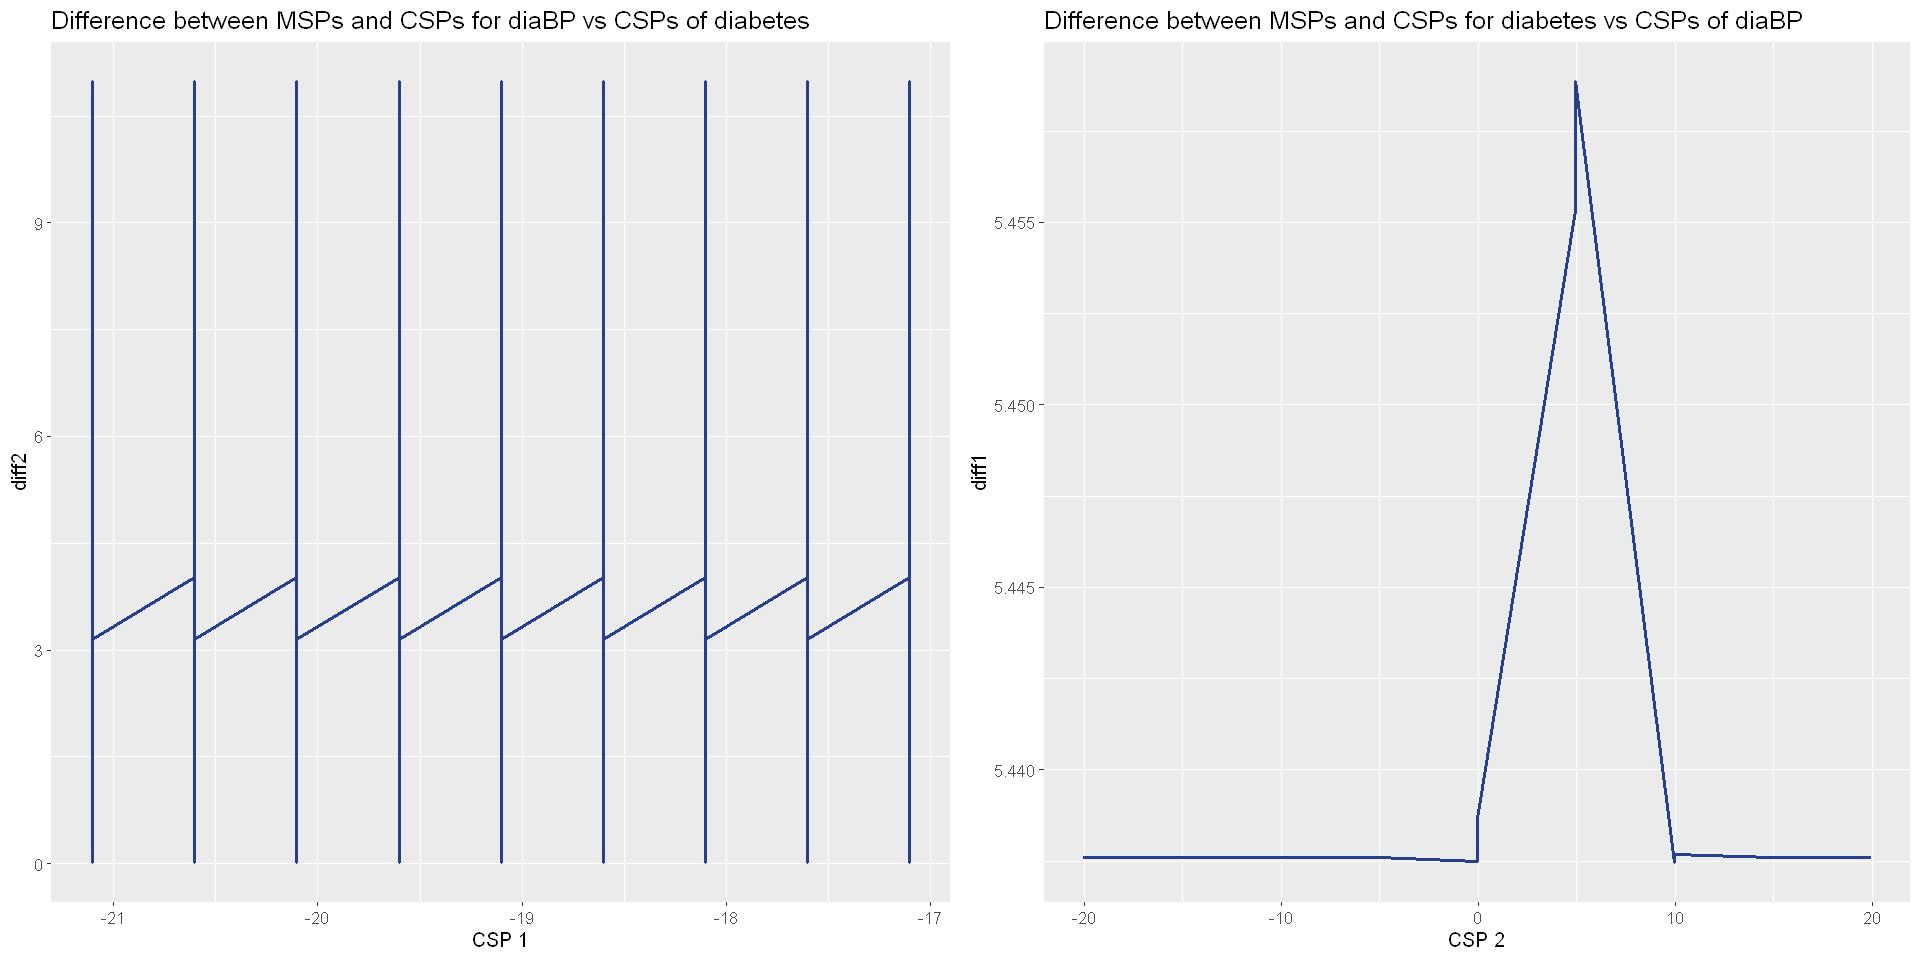

In [42]:
options(repr.plot.width = 16, repr.plot.height = 8)

p1 <- ggplot(tabulated, aes(x=`CSP 1`, y=diff2)) +
    geom_line(color="royalblue4", linewidth=1) +
    ggtitle("Difference between MSPs and CSPs for diaBP vs CSPs of diabetes") +
    theme(
        plot.title = element_text(size = 15),
        axis.title = element_text(size = 12),         
        axis.text.x = element_text(size = 10),        
        axis.text.y = element_text(size = 10))

p2 <- ggplot(tabulated, aes(x=`CSP 2`, y=diff1)) +
    geom_line(color="royalblue4", linewidth=1) +
    ggtitle("Difference between MSPs and CSPs for diabetes vs CSPs of diaBP") +
    theme(
        plot.title = element_text(size = 15),
        axis.title = element_text(size = 12),         
        axis.text.x = element_text(size = 10),        
        axis.text.y = element_text(size = 10))

plot_grid(p1, p2, ncol=2)


"One at a time" assumption not valid! Can not use algorithm 3, so changing the approach to only two missing columns.

### Missing data imputation + classification

In [17]:
fram <- read.csv("Framingham.csv")
fram_mnar <- read.csv("fram_mnar2.csv")

In [18]:
colnames(fram)

[1] "male"            "age"             "education"       "currentSmoker"  
 [5] "cigsPerDay"      "BPMeds"          "prevalentStroke" "prevalentHyp"   
 [9] "diabetes"        "totChol"         "sysBP"           "diaBP"          
[13] "BMI"             "heartRate"       "glucose"         "TenYearCHD"

In [35]:
fcols <- c("male", "education", "currentSmoker", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes", "TenYearCHD")
fcols2 <- c("male", "education", "currentSmoker", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes")
ccols <- c("age", "cigsPerDay", "totChol", "sysBP", "diaBP", "BMI", "heartRate", "glucose")
intcols <- c("age", "cigsPerDay", "totChol", "heartRate", "glucose")
fram_mnar[fcols] <- fram_mnar[fcols] %>% lapply(factor)

In [20]:
fram_mnar$index <- as.numeric(row.names(fram_mnar))

In [21]:
colnames(fram_mnar)[c(9, 12)] # missing columns names and indices

[1] "diabetes" "diaBP"

Stratified train-test split

In [22]:
set.seed(1234)
train_ind <- createDataPartition(fram_mnar$TenYearCHD, p = 0.75, list = FALSE)

In [23]:
train <- fram_mnar[train_ind,]
test  <- fram_mnar[-train_ind,]

In [24]:
predm_train <- make.predictorMatrix(train)
predm_train[,"index"] <- 0
predm_test <- make.predictorMatrix(test)
predm_test[,"index"] <- 0

##### 1. NARFCS

Calculating sensitivity parameters

In [25]:
fram_mnar$diabp_miss <- ifelse(is.na(fram_mnar$diaBP), 1, 0)
fram_mnar$diabetes_miss <- ifelse(is.na(fram_mnar$diabetes), 1, 0)

In [36]:
misscols <- c("diabp_miss", "diabetes_miss")
fram_mnar[misscols] <- fram_mnar[misscols] %>% lapply(factor)
fcols_narfcs <- c(fcols2, misscols)

In [21]:
diabp_obs <- mean(fram[!is.na(fram_mnar$diaBP),]$diaBP)

diabp_missing <- mean(fram[is.na(fram_mnar$diaBP),]$diaBP)

diabp_delta <- diabp_missing - diabp_obs

In [22]:
group <- as.factor(ifelse(is.na(fram_mnar$diabetes), "Missing", "Observed"))
diab_df <- as.data.frame(group)
diab_df$diabetes <- fram$diabetes
diab_table <- table(diab_df)
diab_table

          diabetes
group         0    1
  Missing   589    0
  Observed 1911   61

In [23]:
pos_odds_miss <- 0 / 589
pos_odds_obs <- 61 / 1911
diab_delta <- pos_odds_miss - pos_odds_obs

In [24]:
elicited <- c(exp(diab_delta), diabp_delta)
elicited

[1]  0.9685836 21.1671688

In [29]:
tol <- c(0.25, 2.5)
parms <- rep(list(list(NA)), 2)
names(parms) <- c("diabetes", "diaBP")

l <- list(exp(diab_delta)-1, diabp_delta-10)
u <- list(exp(diab_delta)+1, diabp_delta+10)
step <- list(list(0.25), list(2.5))

MSPmodels <- c("diabetes~diabetes_miss", "diaBP~diabp_miss")
MSPfamily <- c("binomial", "gaussian")

m <- 5
maxit <- 5
method <- rep("", ncol(test))
method[9] <- "mnar.logreg"
method[12] <- "mnar.norm"

base_blots <- list(diabetes = list(ums = "+$"), diaBP = list(ums = "+$"))

In [33]:
calib <- CSPalg2(MSPmodels, MSPfamily, elicited, l, u, step, tol, parms, fram_mnar, m, maxit, method, base_blots, predm_test, 1234)

Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning message:
"Number of logged events: 50"
Warning messa

In [34]:
cbind(calib$calibratedMSP, calib$calibratedCSP)

,MSP 1,MSP 2,CSP 1,CSP 2
,<dbl>,<dbl>,<dbl>,<dbl>
6,0.7922690,20.73560,1.218584,11.16717
7,0.9997558,20.73400,1.468584,11.16717
8,1.1797200,20.73018,1.718584,11.16717
15,0.7922690,23.23560,1.218584,13.66717
16,0.9997558,23.23400,1.468584,13.66717
17,1.1797200,23.23018,1.718584,13.66717


Imputing train and test set independently

In [37]:
csp1_exp <- 1.468584
csp2_exp <- 11.16717

In [38]:
train1 <- train
method1 <- rep("", ncol(train1))
method1[9] <- "mnar.logreg"
method1[12] <- "mnar.norm"
blots1 <- list(diabetes = list(ums = as.character(csp1_exp)), diaBP = list(ums = as.character(csp2_exp)))
imp_train1 <- mice(train1, method=method1, blots=blots1, seed = 234235, print = FALSE, predictorMatrix = predm_train, m=25, maxit=50)  %>% complete(action="long")
imp_train1 <- subset(imp_train1, select = -c(.id, diabp_miss, diabetes_miss))

Warning message:
"Number of logged events: 2500"


In [39]:
test1 <- test
method1 <- rep("", ncol(test1))
method1[9] <- "mnar.logreg"
method1[12] <- "mnar.norm"
blots1 <- list(diabetes = list(ums = as.character(csp1_exp)), diaBP = list(ums = as.character(csp2_exp)))
imp_test1 <- mice(test1, method=method1, blots=blots1, seed = 234235, print = FALSE, predictorMatrix = predm_test, m=25, maxit=50)  %>% complete(action="long")
imp_test1 <- subset(imp_test1, select = -c(.id, diabp_miss, diabetes_miss))

Warning message:
"Number of logged events: 2500"


In [40]:
c(sum(is.na(imp_train1$diaBP)), sum(is.na(imp_train1$diabetes)), sum(is.na(imp_test1$diaBP)), sum(is.na(imp_test1$diabetes)))

[1] 0 0 0 0

In [41]:
imp_train1[intcols] <- imp_train1[intcols] %>% lapply(as.integer)
imp_test1[intcols] <- imp_test1[intcols] %>% lapply(as.integer)

In [42]:
orgtest <- rbind(test1, test1, test1, test1)
orgtrain <- rbind(train1, train1, train1, train1)
imptest <- subset(imp_test1, .imp <= 4)
imptrain <- subset(imp_train1, .imp <= 4)

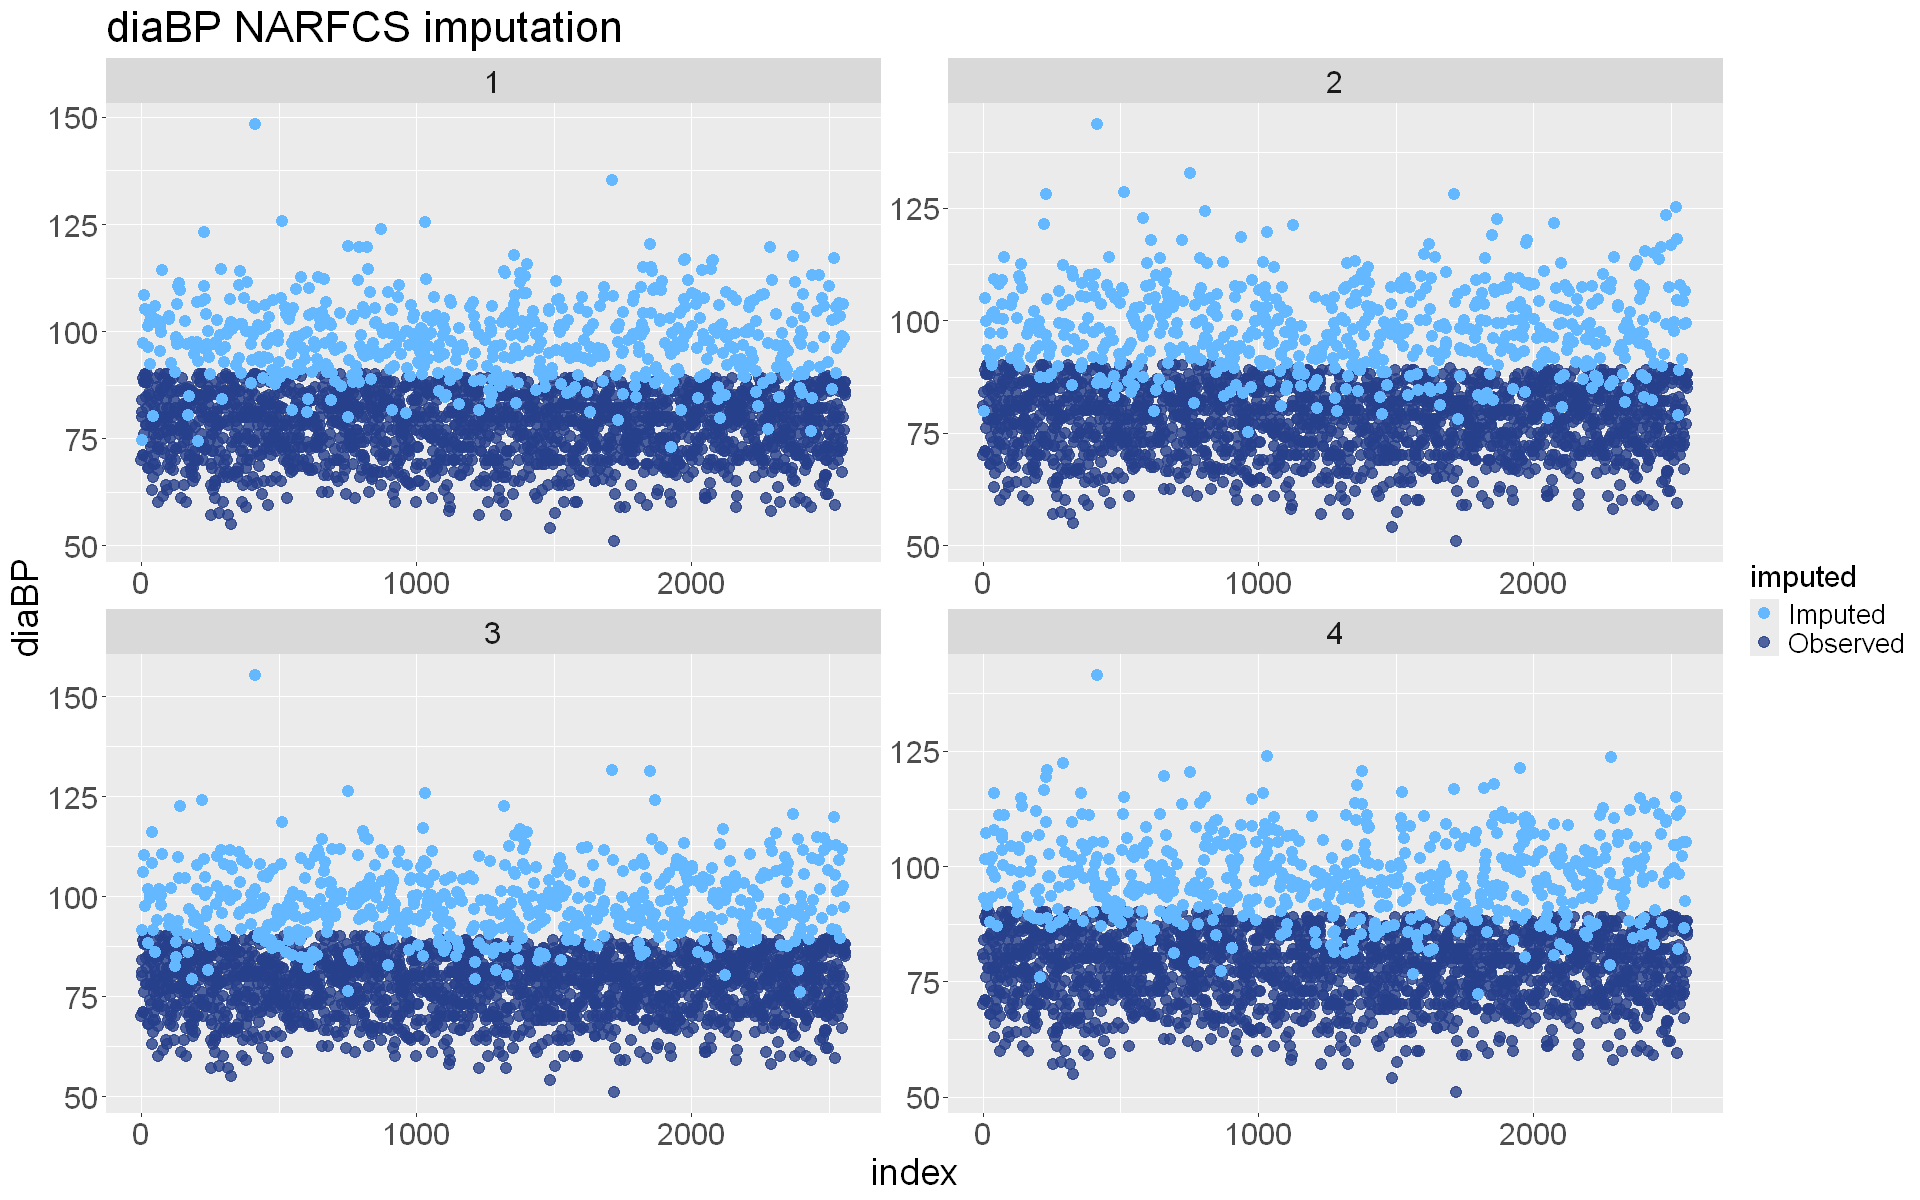

In [43]:
options(repr.plot.width = 16, repr.plot.height = 10)
visImpMul(orgtrain, orgtest, imptrain, imptest, "diaBP", "NARFCS")

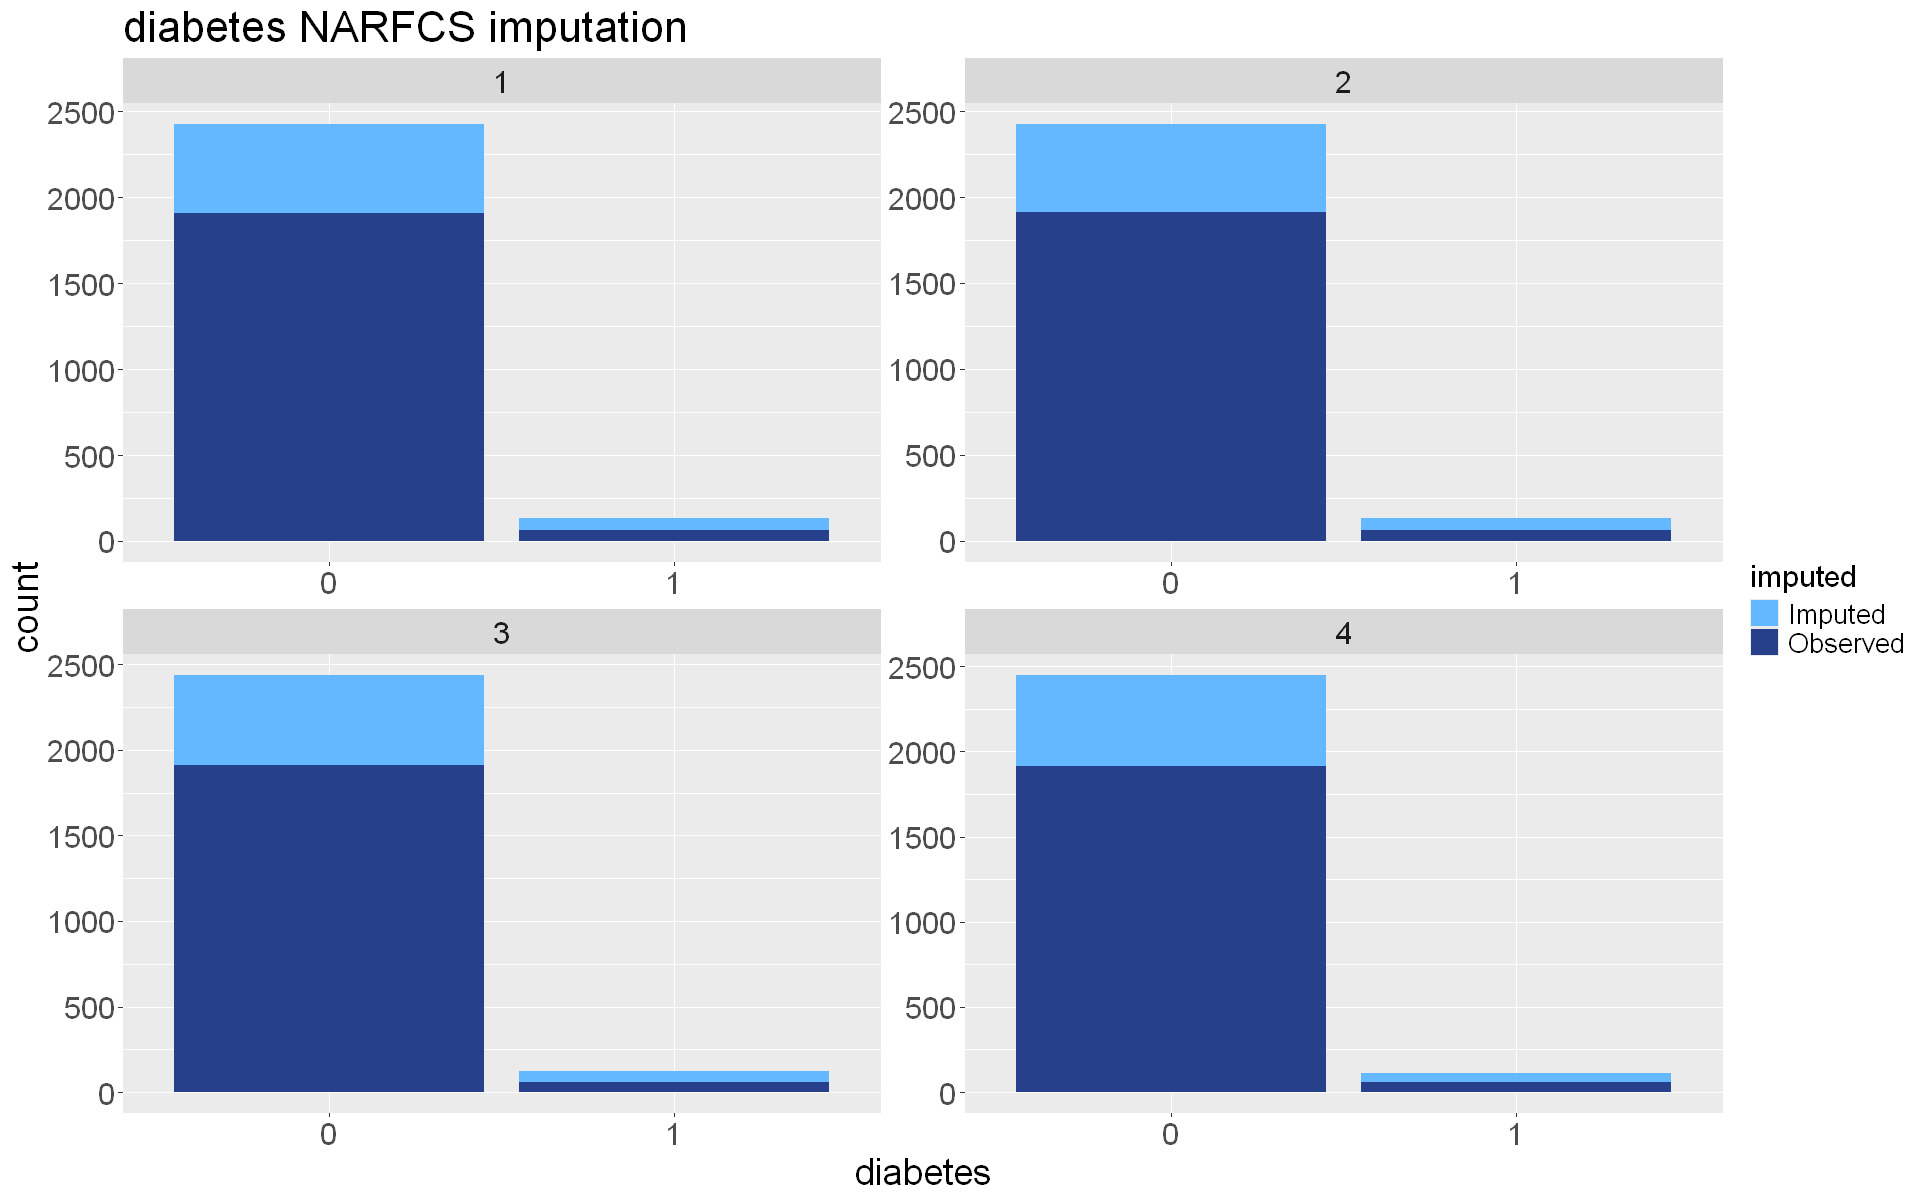

In [44]:
visImpMulCat(orgtrain, orgtest, imptrain, imptest, "diabetes", "NARFCS")

In [37]:
csp1_exp <- 1.468584
csp2_exp <- 11.16717
blots <- list(diabetes = list(ums = as.character(csp1_exp)), diaBP = list(ums = as.character(csp2_exp)))

method1_cls <- rep("", ncol(fram_mnar))
method1_cls[9] <- "mnar.logreg"
method1_cls[12] <- "mnar.norm"

In [38]:
fcols_narfcs

[1] "male"            "education"       "currentSmoker"   "BPMeds"         
[5] "prevalentStroke" "prevalentHyp"    "diabetes"        "diabp_miss"     
[9] "diabetes_miss"

In [41]:
sim1 <- simulate_narfcs(100, method1_cls, 5, 5, "narfcs.csv", blots, intcols, fcols_narfcs)


 iter imp variable
  1   1  diabetes  diaBP
  1   2  diabetes  diaBP
  1   3  diabetes  diaBP
  1   4  diabetes  diaBP
  1   5  diabetes  diaBP
  2   1  diabetes  diaBP
  2   2  diabetes  diaBP
  2   3  diabetes  diaBP
  2   4  diabetes  diaBP
  2   5  diabetes  diaBP
  3   1  diabetes  diaBP
  3   2  diabetes  diaBP
  3   3  diabetes  diaBP
  3   4  diabetes  diaBP
  3   5  diabetes  diaBP
  4   1  diabetes  diaBP
  4   2  diabetes  diaBP
  4   3  diabetes  diaBP
  4   4  diabetes  diaBP
  4   5  diabetes  diaBP
  5   1  diabetes  diaBP
  5   2  diabetes  diaBP
  5   3  diabetes  diaBP
  5   4  diabetes  diaBP
  5   5  diabetes  diaBP


Warning message:
"Number of logged events: 50"



 iter imp variable
  1   1  diabetes  diaBP
  1   2  diabetes  diaBP
  1   3  diabetes  diaBP
  1   4  diabetes  diaBP
  1   5  diabetes  diaBP
  2   1  diabetes  diaBP
  2   2  diabetes  diaBP
  2   3  diabetes  diaBP
  2   4  diabetes  diaBP
  2   5  diabetes  diaBP
  3   1  diabetes  diaBP
  3   2  diabetes  diaBP
  3   3  diabetes  diaBP
  3   4  diabetes  diaBP
  3   5  diabetes  diaBP
  4   1  diabetes  diaBP
  4   2  diabetes  diaBP
  4   3  diabetes  diaBP
  4   4  diabetes  diaBP
  4   5  diabetes  diaBP
  5   1  diabetes  diaBP
  5   2  diabetes  diaBP
  5   3  diabetes  diaBP
  5   4  diabetes  diaBP
  5   5  diabetes  diaBP


Warning message:
"Number of logged events: 50"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict

In [60]:
sim1

V1        V2        V3        V4 
0.7164319 0.7519249 0.8163224 0.8293740

##### 2. Random indicator

In [22]:
boxcox(fram_mnar$diaBP)

Warning message in is.not.finite.warning(x):
"There were 615 nonfinite values in x : 615 NA's"
Warning message in boxcox.default(fram_mnar$diaBP):
"615 observations with NA/NaN/Inf in 'x' removed."



Results of Box-Cox Transformation
---------------------------------

Objective Name:                  PPCC

Data:                            fram_mnar$diaBP

Number NA/NaN/Inf's Removed:     615

Sample Size:                     1946

 lambda      PPCC
   -2.0 0.9527425
   -1.5 0.9604733
   -1.0 0.9671780
   -0.5 0.9729068
    0.0 0.9777120
    0.5 0.9816476
    1.0 0.9847680
    1.5 0.9871274
    2.0 0.9887793

In [23]:
lambda <- 2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 615 rows containing non-finite outside the scale range (`stat_bin()`)."
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 615 rows containing non-finite outside the scale range (`stat_bin()`)."


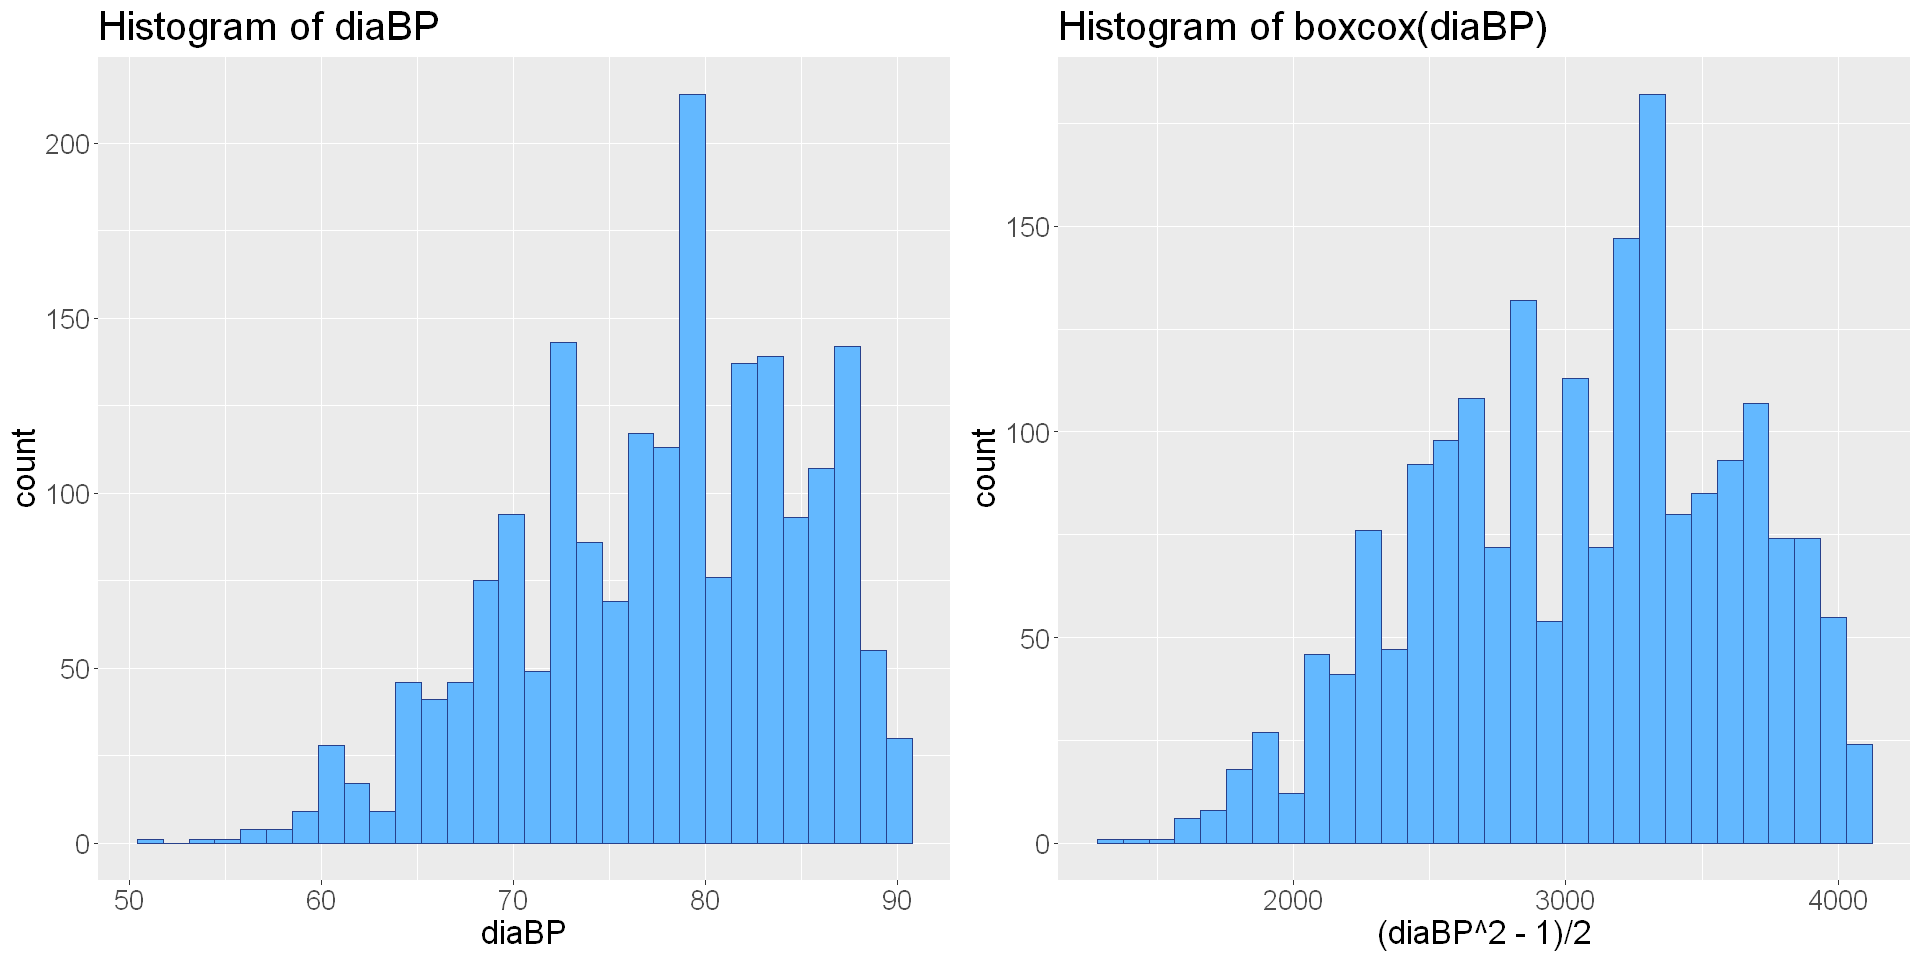

In [6]:
p1 <- ggplot(fram_mnar, aes(x=diaBP)) + 
  geom_histogram(color="royalblue4", fill="steelblue1") + 
  ggtitle("Histogram of diaBP") +
  theme(
    plot.title = element_text(size = 24),
    axis.title = element_text(size = 20),         
    axis.text.x = element_text(size = 16),        
    axis.text.y = element_text(size = 16),
    strip.text = element_text(size = 16))

p2 <- ggplot(fram_mnar, aes(x=(diaBP^2 - 1)/2)) + 
  geom_histogram(color="royalblue4", fill="steelblue1") +
  ggtitle("Histogram of boxcox(diaBP)") +
  theme(
    plot.title = element_text(size = 24),
    axis.title = element_text(size = 20),         
    axis.text.x = element_text(size = 16),        
    axis.text.y = element_text(size = 16),
    strip.text = element_text(size = 16))

options(repr.plot.width = 16, repr.plot.height = 8)
plot_grid(p1, p2, ncol=2)

In [19]:
colnames(fram_mnar)[c(4, 5, 9, 11, 12)] # missing columns names and indices

[1] "currentSmoker" "cigsPerDay"    "diabetes"      "sysBP"        
[5] "diaBP"

Excluding missing variables from predictor matrix

In [26]:
predm_train2 <- predm_train
predm_train2["diaBP", "diabetes"] <- 0
predm_train2["diabetes", "diaBP"] <- 0

In [27]:
predm_test2 <- predm_test
predm_test2["diaBP", "diabetes"] <- 0
predm_test2["diabetes", "diaBP"] <- 0

In [31]:
train2 <- train
train2$diaBP <- (train2$diaBP^lambda - 1)/lambda
train2$diabetes <- as.numeric(as.character(train2$diabetes))

[1] NA  1  0

In [32]:
test2 <- test
test2$diaBP <- (test2$diaBP^lambda - 1)/lambda
test2$diabetes <- as.numeric(as.character(test2$diabetes))

In [34]:
method2 <- rep("", ncol(train2))
method2[c(12, 9)] <- "ri"
imp_train2 <- mice(train2, method=method2, predictorMatrix=predm_train2, print=FALSE, m=1, maxit=1) %>% complete()
imp_train2 <- subset(imp_train2, select = -c(diabp_miss, diabetes_miss))

Warning message:
"Number of logged events: 2"


In [35]:
imp_test2 <- mice(test2, method=method2, predictorMatrix=predm_test2, print=FALSE, m=1, maxit=1) %>% complete()
imp_test2 <- subset(imp_test2, select = -c(diabp_miss, diabetes_miss))

Warning message:
"Number of logged events: 2"


In [36]:
imp_train2$diabetes <- rescale(imp_train2$diabetes)
imp_train2$diabetes <- ifelse(imp_train2$diabetes > 0.5, 1, 0)
imp_train2$diabetes <- as.factor(imp_train2$diabetes)

In [37]:
imp_test2$diabetes <- rescale(imp_test2$diabetes)
imp_test2$diabetes <- ifelse(imp_test2$diabetes > 0.5, 1, 0)
imp_test2$diabetes <- as.factor(imp_test2$diabetes)

In [38]:
intcols <- c("age", "cigsPerDay", "totChol", "heartRate", "glucose")
imp_train2[intcols] <- imp_train2[intcols] %>% lapply(as.integer)
imp_test2[intcols] <- imp_test2[intcols] %>% lapply(as.integer)

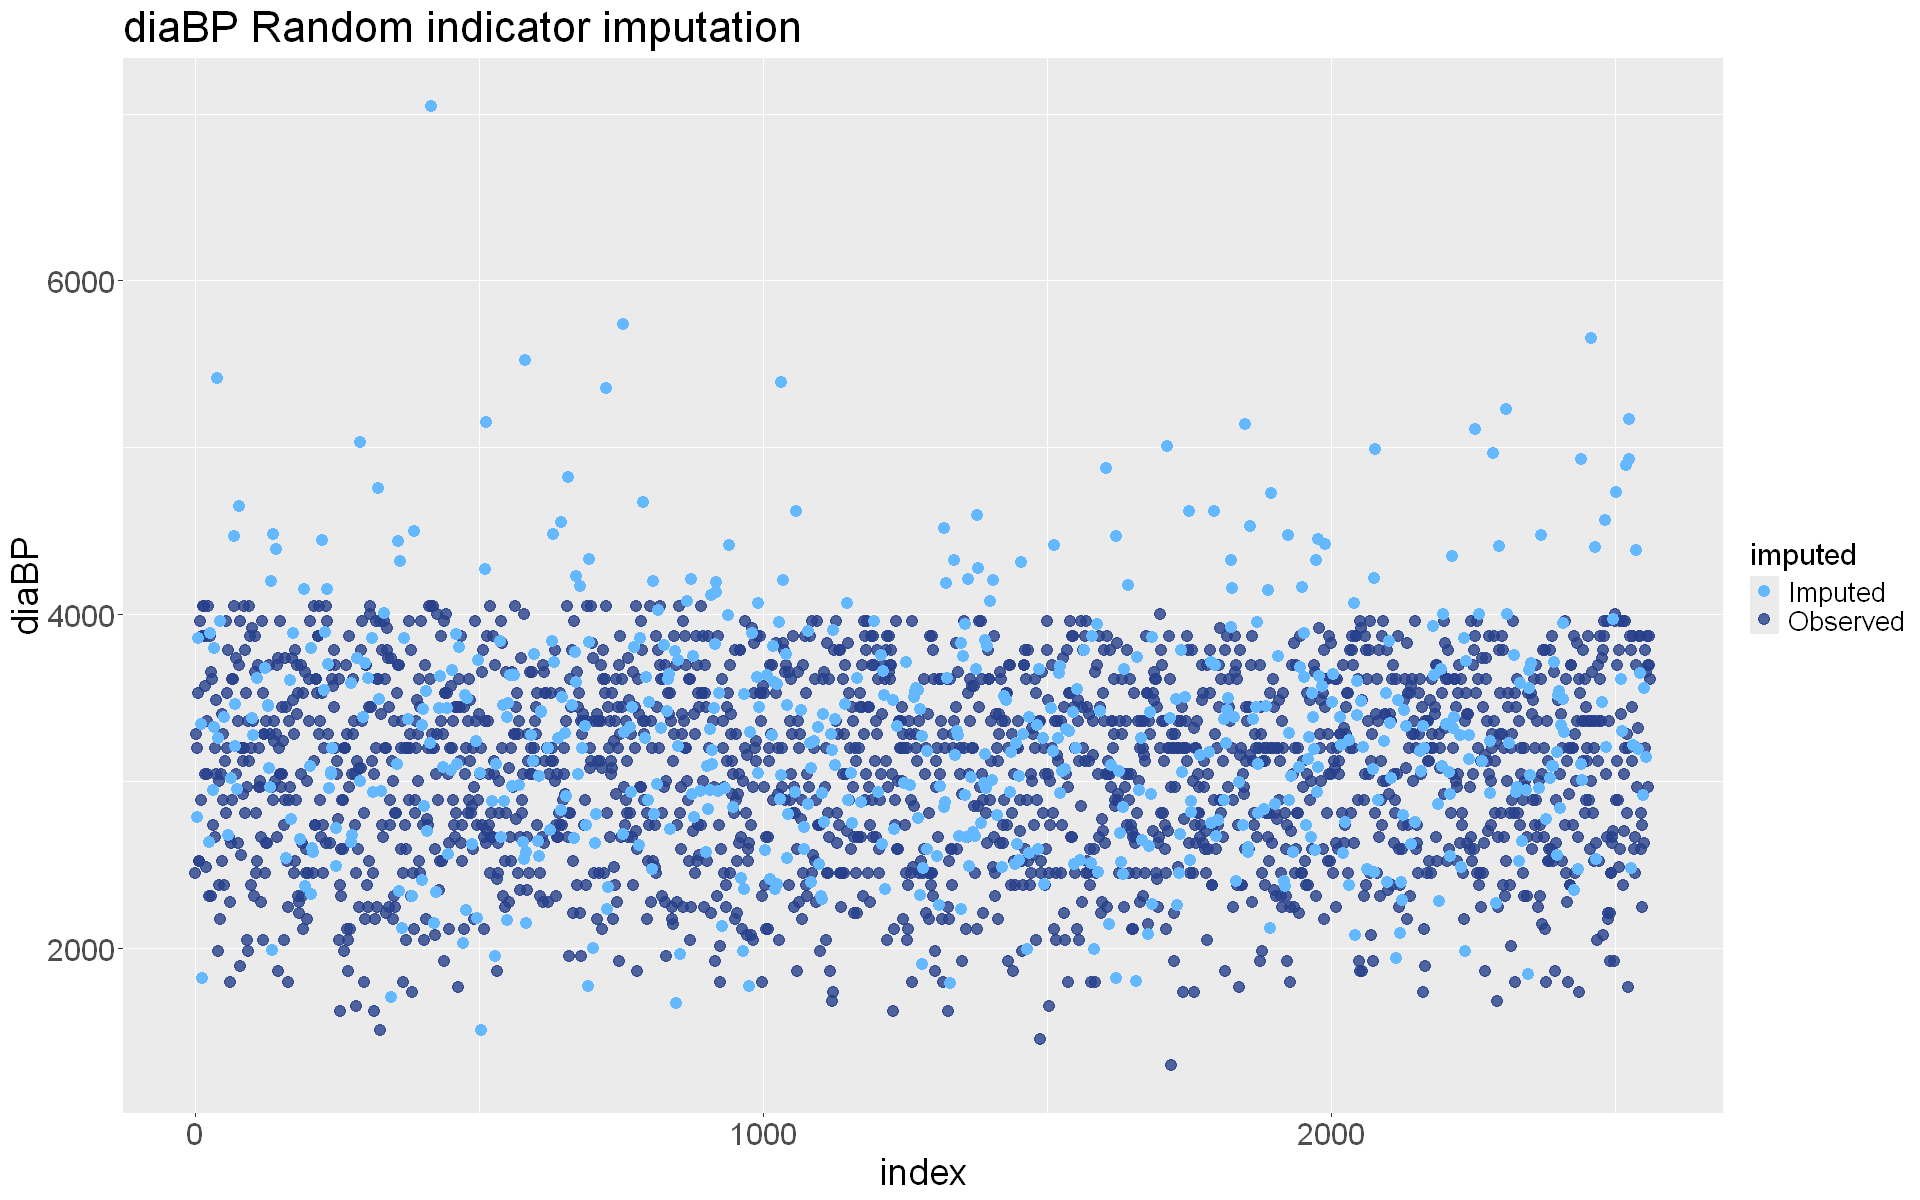

In [39]:
options(repr.plot.width = 16, repr.plot.height = 10)
visImpCont(train2, test2, imp_train2, imp_test2, "diaBP", "Random indicator")

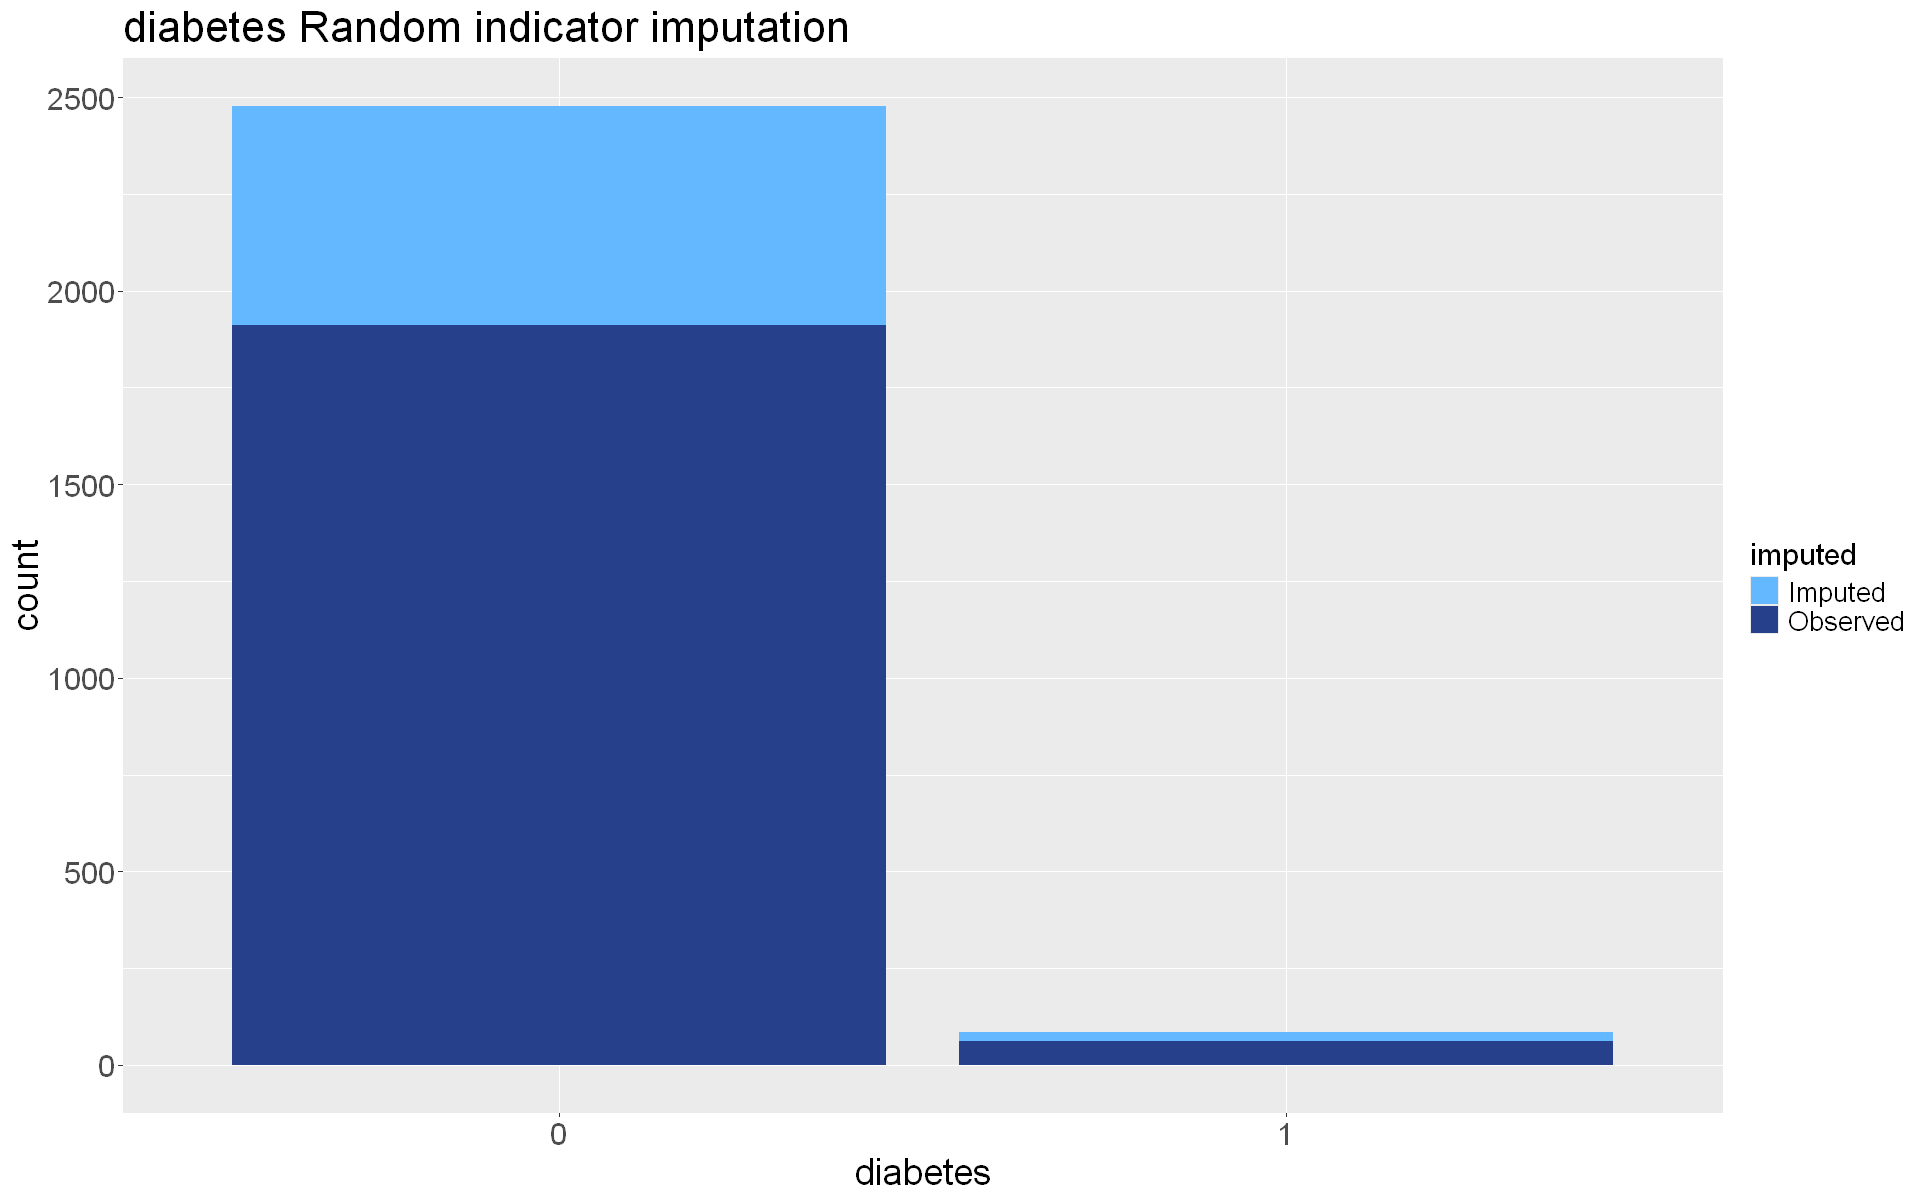

In [40]:
visImpCat(train2, test2, imp_train2, imp_test2, "diabetes", "Random indicator")

In [50]:
colnames(fram_mnar)

[1] "male"            "age"             "education"       "currentSmoker"  
 [5] "cigsPerDay"      "BPMeds"          "prevalentStroke" "prevalentHyp"   
 [9] "diabetes"        "totChol"         "sysBP"           "diaBP"          
[13] "BMI"             "heartRate"       "glucose"         "TenYearCHD"     
[17] "index"           "diabp_miss"      "diabetes_miss"

In [51]:
fram_mnar <- subset(fram_mnar, select=-c(diabp_miss, diabetes_miss))

In [53]:
method2_cls <- rep("", ncol(fram_mnar))
method2_cls[c(12, 9)] <- "ri"

In [39]:
sim2 <- simulate_ri(100, method2_cls, 1, 1, "ri.csv", intcols, fcols2)


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8031696; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6795563; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6795563; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6795563; time: 0.0 min

[Tune-x] 


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7883288; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6550839; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6550839; time: 0.0 min

[Tune-x] 4: cp=0.31; min


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7914770; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6814980; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6814980; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6814980; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8196707; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6940798; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.69


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algoryt


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8106573; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6971182; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6971182; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6971182; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5163394; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7978549; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6858938; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6858938; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6858938; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5134042; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7977707; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6541401; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.65


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7954982; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6762810; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6642367; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.5624934; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 2"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8228935; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6848967; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: a


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8186694; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6743074; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6743074; time: 0.0 min

[Tune-x] 4: cp=0.31; min


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8013385; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6551205; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6519408; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.5864401; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5174830; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 2"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8119463; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6681375; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.66


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8002595; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6646634; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6646634; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6295924; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5145405; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdepth=5

[Tune-y] 6: acc.test.mean=0.5145405; tim


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction 


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8126234; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6934007; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6934007; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6934007; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5161663; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdepth=5

[Tune-y] 6: acc.test.mean=0.5161663; tim


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8046092; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6599508; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6599508; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6599508; time: 0.0 min

[Tune-x] 


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8165079; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6825397; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6644444; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6644444; time: 0.0 min

[Tune-x] 


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7998713; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6886905; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6886905; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6886905; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5171575; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdepth=5

[Tune-y] 6: acc.test.mean=0.5171575; tim


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7931186; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6827338; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6572071; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6572071; time: 0.0 min

[Tune-x] 


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Ty


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7941550; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.7001378; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: a


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7844857; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6651160; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6651160; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6227667; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7947794; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6656102; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6656102; time: 0.0 min

[Tune-x] 4: cp=0.31; min


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7961462; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6604637; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6604637; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6604637; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5137386; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8041896; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6831888; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6831888; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6831888; time: 0.0 min

[Tune-x] 


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8029263; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6671961; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6671961; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.5676731; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5174719; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbu


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7958061; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6778528; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6778528; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6778528; time: 0.0 min

[Tune-x] 


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
max


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7864764; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6994024; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6994024; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6994024; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5173195; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7973527; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6653919; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6477263; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6139723; time: 0.0 min

[Tune-x] 


 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"



 iter imp variable
  1   1  diabetes  diaBP


Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8226835; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5



 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8037855; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6788644; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6788644; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6788644; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5135647; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, .


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7873695; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6870747; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6870747; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6870747; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5166649; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8009554; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6875796; time: 0.


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
max


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7935226; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6724890; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.67


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8014016; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6746017; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6507755; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.5875499; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8150308; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8087878; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6719329; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6719329; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6719329; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5145415; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7970937; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6856717; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.68


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8029617; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6744664; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.67


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7969465; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6606218; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6606218; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6215742; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5173225; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdepth=5

[Tune-y] 6: acc.test.mean=0.5173225; tim


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0


 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"



 iter imp variable
  1   1  diabetes  diaBP


Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7797468; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6835443; time: 0.


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8073837; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6891647; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6891647; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6891647; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5132353; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message i


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7937989; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6552848; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6552848; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6552848; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5148769; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdepth=5

[Tune-y] 6: acc.test.mean=0.5148769; tim


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8014654; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6637159; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6637159; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.5620805; time: 0.0 min

[Tune-x] 


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7944529; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6775038; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6775038; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6775038; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8138127; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6662486; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6662486; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6662486; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5155209; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8098921; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6788303; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6788303; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6788303; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5166614; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   - 


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8048399; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6499111; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6499111; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6499111; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5116308; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"



 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart fo


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8103026; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5



 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Im


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tuna


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp     


 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"



 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbu


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8155803; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6988871; time: 0.


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -      


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8040738; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6733370; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6733370; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6345453; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5178152; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7969143; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6627881; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6627881; time: 0.0 min

[Tune-x] 4: cp=0.31; min


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7984102; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6572337; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: a


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8212515; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6782660; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6782660; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6782660; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5150284; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdepth=5

[Tune-y] 6: acc.test.mean=0.5150284; tim


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,2


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7884316; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7975376; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6733214; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6733214; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6733214; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5158454; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdepth=5

[Tune-y] 6: acc.test.mean=0.5158454; tim


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8165329; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6660364; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6660364; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6660364; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5158408; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: ac


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
max


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7986082; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6598091; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6598091; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6598091; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5146974; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8236404; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6981311; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6981311; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6981311; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5173180; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8135861; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6654028; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.66


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7898734; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6737342; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6737342; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6737342; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5151899; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7999398; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6682466; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6682466; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6296390; time: 0.0 min

[Tune-x] 


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8046114; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6648679; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6648679; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6648679; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7955690; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6687244; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6687244; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6687244; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.4812227; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdepth=5

[Tune-y] 6: acc.test.mean=0.4812227; tim


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8076555; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6854864; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.66


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8082244; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6744146; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6744146; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6744146; time: 0.0 min

[Tune-x] 


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8033741; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6945546; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.69


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7995562; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6598989; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6545191; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.5918609; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5155134; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7979114; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6773055; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6773055; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6773055; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5140560; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8008212; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6598701; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6506491; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.5892353; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5179721; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8059831; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6777992; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.67


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7894474; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6825742; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6825742; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6825742; time: 0.0 min

[Tune-x] 


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message:
"glm.fit: algorytm nie zbiegł się"
Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -  


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8106943; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.7170064; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6752207; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6752207; time: 0.0 min

[Tune-x] 


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7905461; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6803337; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.68


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8169346; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6640233; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6640233; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.5647549; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5165009; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdep


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TR


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.8028526; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6963550; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.69


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7990506; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6791139; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6791139; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6791139; time: 0.0 min

[Tune-x] 5: cp=0.41; minbucket=3; maxdepth=5

[Tune-y] 5: acc.test.mean=0.5151899; time: 0.0 min

[Tune-x] 6: cp=0.51; minbucket=3; maxdepth=5

[Tune-y] 6: acc.test.mean=0.5151899; tim


 iter imp variable
  1   1  diabetes  diaBP

 iter imp variable
  1   1  diabetes  diaBP


Warning message:
"Number of logged events: 1"
Warning message in stats::predict.lm(object, ...):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
[Tune] Started tuning learner classif.rpart for parameter set:

              Type len Def                        Constr Req Tunable Trafo
cp        discrete   -   - 0.01,0.11,0.21,0.31,0.41,0.51   -    TRUE     -
minbucket discrete   -   -                        3,7,10   -    TRUE     -
maxdepth  discrete   -   -              5,10,15,20,25,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: cp=0.01; minbucket=3; maxdepth=5

[Tune-y] 1: acc.test.mean=0.7888142; time: 0.0 min

[Tune-x] 2: cp=0.11; minbucket=3; maxdepth=5

[Tune-y] 2: acc.test.mean=0.6846564; time: 0.0 min

[Tune-x] 3: cp=0.21; minbucket=3; maxdepth=5

[Tune-y] 3: acc.test.mean=0.6846564; time: 0.0 min

[Tune-x] 4: cp=0.31; minbucket=3; maxdepth=5

[Tune-y] 4: acc.test.mean=0.6846564; time: 0.0 min

[Tune-x] 

In [38]:
sim2

glm       knn        dt        rf 
0.6651017 0.7230047 0.7949922 0.7323944